https://www.kaggle.com/code/kanncaa1/recurrent-neural-network-with-pytorch/notebook 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("input/"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
# Import Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# check if we speed up computation by using a gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

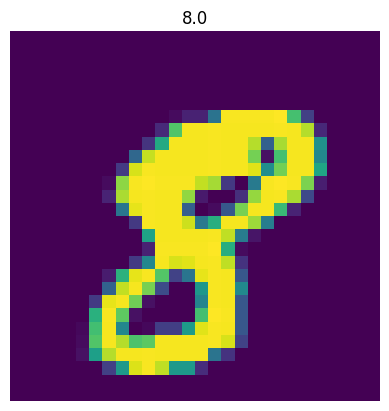

In [4]:
# Prepare Dataset
# load data
train = pd.read_csv(r"input/train.csv",dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [5]:
# Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        """
        nn.RNN inputs: input_size, hidden_size, num_layers, nonlinearity, bias, batch_first, dropout, bidirectional
        """
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        """
        For batches, h0 should be of shape (N,L,H_in)
        N = batch size
        L = sequence length
        H_in = input_size
        """
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)).to(device)
            
        # One time step
        out, hn = self.rnn(x, h0.detach())
        # print(out[0,:,0])
        out = self.fc(out[:, -1, :]) # only care about the final output making this a multi input, single output RNN
        return out

# batch_size, epoch and iteration
batch_size = 100
n_iters = 8000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create RNN

""" 
Based on their input dimensions, what makes this a recurrent neural network is the fact that the input dimenions
is only 28 but each image is 28x28. Thus for a single image, it is a sequence of length 28, each input being a size of 28
"""

input_dim = 28    # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = 10   # output dimension

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

model.to(device) # send to gpu

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [6]:
temp = torch.from_numpy(features_numpy[10]).view(-1, 28, 28)
print("new shape: {}".format(temp.shape))

new shape: torch.Size([1, 28, 28])


In [7]:
seq_dim = 28  
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train  = Variable(images.view(-1, seq_dim, input_dim)).requires_grad_().to(device)
        labels = Variable(labels).to(device)
            
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 250 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images = Variable(images.view(-1, seq_dim, input_dim)).to(device)

                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                # print(labels.shape)
                # print(train.shape)
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data.item(), accuracy))

Iteration: 500  Loss: 1.8546955585479736  Accuracy: 34.53571319580078 %
Iteration: 1000  Loss: 1.4300334453582764  Accuracy: 48.42856979370117 %
Iteration: 1500  Loss: 0.8009386658668518  Accuracy: 77.20237731933594 %
Iteration: 2000  Loss: 0.6439802646636963  Accuracy: 83.77381134033203 %
Iteration: 2500  Loss: 0.288480669260025  Accuracy: 88.53571319580078 %
Iteration: 3000  Loss: 0.18897008895874023  Accuracy: 90.51190185546875 %
Iteration: 3500  Loss: 0.4943884313106537  Accuracy: 91.29762268066406 %
Iteration: 4000  Loss: 0.15798763930797577  Accuracy: 92.67857360839844 %
Iteration: 4500  Loss: 0.6958481669425964  Accuracy: 88.28571319580078 %
Iteration: 5000  Loss: 0.15445661544799805  Accuracy: 93.73809814453125 %
Iteration: 5500  Loss: 0.22906625270843506  Accuracy: 94.26190185546875 %
Iteration: 6000  Loss: 0.19136780500411987  Accuracy: 94.42857360839844 %
Iteration: 6500  Loss: 0.0662650465965271  Accuracy: 95.57142639160156 %
Iteration: 7000  Loss: 0.15896014869213104  Accu

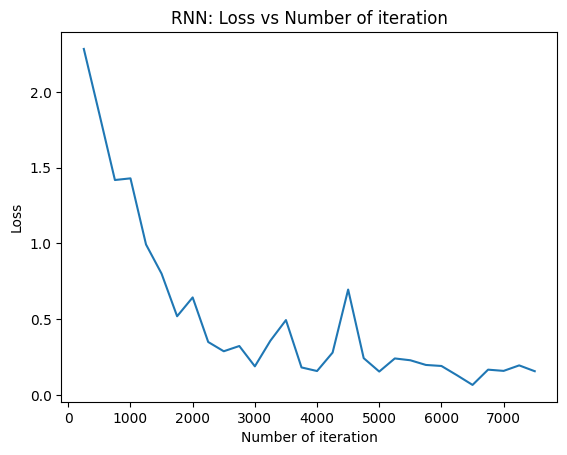

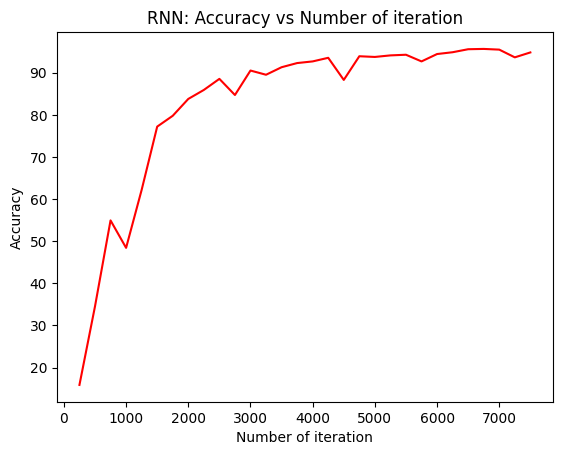

In [8]:
# visualization loss 
loss_list = [loss.cpu() for loss in loss_list]
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()